In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import multivariate_normal

# Load data
df = pd.read_csv('../../Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [11]:
# Preprocessing
df = df.drop('CustomerID', axis=1)
df['Genre'] = df['Genre'].map({'Male': 0, 'Female': 1})
X = df.iloc[:, [1, 2, 3]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
class GMMScratch:
    def __init__(self, n_components=3, max_iters=100, tol=1e-4):
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol
        self.means = None
        self.covariances = None
        self.weights = None

    def fit(self, X):
        n_samples, n_features = X.shape
        idx = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[idx]
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])
        self.weights = np.ones(self.n_components) / self.n_components
        log_likelihood = -np.inf
        for i in range(self.max_iters):
            responsibilities = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                reg_cov = np.eye(n_features) * 1e-6
                pdf = multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k] + reg_cov)
                responsibilities[:, k] = self.weights[k] * pdf
            responsibility_sum = responsibilities.sum(axis=1)[:, np.newaxis]
            responsibilities = responsibilities / responsibility_sum
            Nk = responsibilities.sum(axis=0)
            for k in range(self.n_components):
                self.means[k] = (responsibilities[:, k][:, np.newaxis] * X).sum(axis=0) / Nk[k]
                diff = X - self.means[k]
                weighted_diff = responsibilities[:, k][:, np.newaxis] * diff
                self.covariances[k] = np.dot(weighted_diff.T, diff) / Nk[k]
                self.weights[k] = Nk[k] / n_samples
            new_log_likelihood = np.sum(np.log(responsibility_sum))
            if np.abs(new_log_likelihood - log_likelihood) < self.tol:
                break
            log_likelihood = new_log_likelihood
            
    def predict(self, X):
        n_samples = X.shape[0]
        probs = np.zeros((n_samples, self.n_components))
        reg_cov = np.eye(X.shape[1]) * 1e-6
        for k in range(self.n_components):
            pdf = multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k] + reg_cov)
            probs[:, k] = self.weights[k] * pdf
        return np.argmax(probs, axis=1)

In [13]:
# Tuning Loop
best_k = -1
best_sil = -1
best_db = float('inf')
results = []

print("Tuning GMM Parameters:")
print(f"{'k':<5} {'Silhouette':<15} {'Davies-Bouldin':<15}")

for k in range(2, 11):
    gmm = GMMScratch(n_components=k)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    
    if len(np.unique(labels)) < 2:
        continue
        
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    
    results.append((k, sil_score, db_score))
    print(f"{k:<5} {sil_score:<15.4f} {db_score:<15.4f}")
    
    if sil_score > best_sil:
        best_sil = sil_score
        best_db = db_score
        best_k = k

print(f"\nBest Configuration: k={best_k}")
print(f"Best Silhouette Score: {best_sil:.4f}")
print(f"Davies-Bouldin Score: {best_db:.4f}")

# Fit final model
gmm_final = GMMScratch(n_components=best_k)
gmm_final.fit(X_scaled)
labels = gmm_final.predict(X_scaled)

Tuning GMM Parameters:
k     Silhouette      Davies-Bouldin 
2     0.3240          1.2679         
3     0.3348          1.0191         
4     0.3630          1.0195         
5     0.3134          1.3393         
6     0.2230          1.5413         
7     0.3434          1.1228         
8     0.2545          1.4086         
9     0.3222          1.5634         
10    0.2317          2.2146         

Best Configuration: k=4
Best Silhouette Score: 0.3630
Davies-Bouldin Score: 1.0195


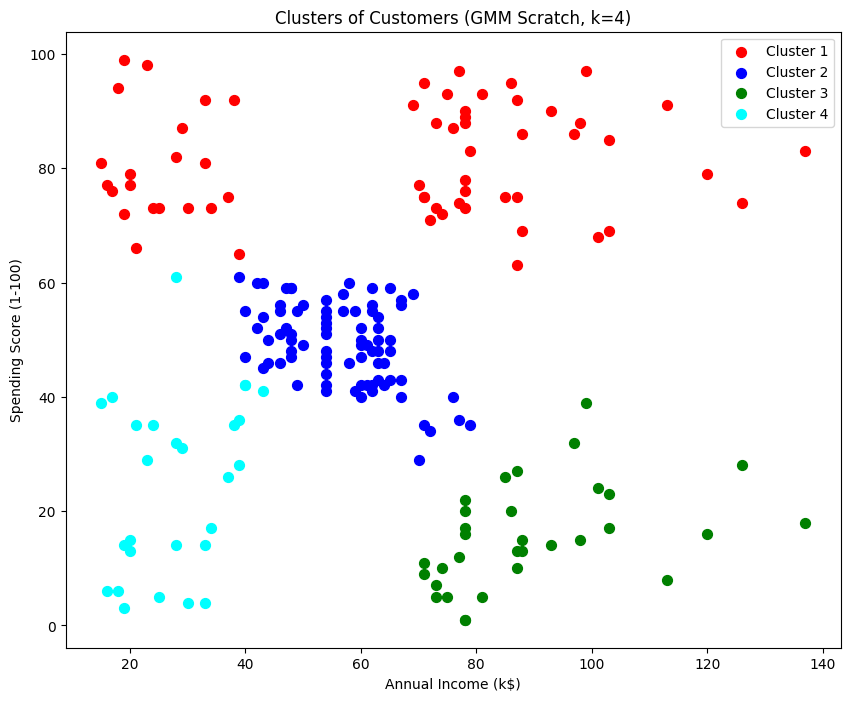

In [14]:
# Visualization
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'cyan', 'magenta', 'orange', 'purple', 'brown', 'pink', 'gray']

for i in range(best_k):
    plt.scatter(X[labels == i, 1], X[labels == i, 2], s=50, c=colors[i % len(colors)], label=f'Cluster {i+1}')

plt.title(f'Clusters of Customers (GMM Scratch, k={best_k})')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()